<a href="https://colab.research.google.com/github/ZohebAbai/Deep-Learning-Projects/blob/master/05_TF_Metric_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Metric Learning: Image Similarity

Metric learning aims to train models that can embed inputs into a high-dimensional space such that "similar" inputs are pulled closer to each other and "dissimilar" inputs are pushed farther apart. Once trained, these models can produce embeddings for downstream systems where such similarity is useful, for instance as a ranking signal for search or as a form of pretrained embedding model for another supervised problem.

Steps Covered:

1. Import Libraries
2. Defining Hyperparameters/Configs
3. Data Preparation -- Downloading, Resizing, Data Augmentation and Splitting
4. Data Visualization
5. Model Building
6. Transfer Learning
7. Model Evaluation -- Indexing, Calibration, Querying, Confusion Matrix and Visualize Clusters

## Import Libraries

In [1]:
!pip install -q tensorflow_similarity

     |████████████████████████████████| 189 kB 8.3 MB/s 
     |████████████████████████████████| 86 kB 5.3 MB/s 
     |████████████████████████████████| 13.5 MB 68.9 MB/s 
     |████████████████████████████████| 4.2 MB 57.9 MB/s 
     |████████████████████████████████| 188 kB 79.7 MB/s 
     |████████████████████████████████| 1.1 MB 68.4 MB/s 


In [2]:
import os
import random
from time import time
import numpy as np
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits import axes_grid1

import tensorflow as tf
from tensorflow import keras
import tensorflow_similarity as tfsim
tfsim.utils.tf_cap_memory()  # Avoid GPU memory blow up

from IPython.display import Markdown, display

## Define Hyperparams/Configs

In [3]:
def get_configs(**kwargs):
    return namedtuple('GenericDict', kwargs.keys())(**kwargs)

configs = get_configs(
    img_size = 224,
    training_classes = 24,
    examples_per_class_per_batch = 4, 
    num_targets = 200,
    num_queries = 300,
    embedding_size = 128,
    max_lr= 1e-03,
    steps_per_epoch = 100,
    val_steps = 50,
    n_epochs= 30,
    )

## Data preparation
In this first step, we are going to load the Oxford-IIIT pet dataset directly from the TensorFlow dataset catalog. This dataset has 37 classes representing different breeds of cats and dogs with roughly 200 images for each class.

However, the dataset images are not of the same size, so we will need to resize them as part of the data loading. The  pre-trained EfficientNet model expects images to be 224x224 in the default configuration. However, because we use a random crop and resize layer as part of our augmentation strategy, it is important to have images that are slightly larger than the EfficientNet backbone's input size. 

**NOTE: Do not consider a dataset which is big in size or have huge number of classes. It won't fit in memory**

In [4]:
# randomly pick the classes to be used for training.
train_cls = random.sample(range(37), k=configs.training_classes)
classes_per_batch = min(37, configs.training_classes)
print(f"Class IDs seen during training {train_cls}")

# preprocessing function that resizes images to ensure all images are the same shape
def resize(img, label):
    size = 299  
    with tf.device("/cpu:0"):
        img = tf.cast(img, dtype="int32")
        img = tf.image.resize_with_pad(img, size, size)
        return img, label

# Image Augmentation
def img_augmentation(img_batch, y, *args):
    # random resize and crop. Increase the size before we crop.
    img_batch = tf.keras.layers.RandomCrop(configs.img_size, configs.img_size)(img_batch)
    # random horizontal flip
    img_batch = tf.image.random_flip_left_right(img_batch)
    return img_batch, y

Class IDs seen during training [29, 0, 23, 19, 16, 18, 22, 8, 32, 24, 10, 20, 17, 7, 2, 11, 1, 27, 6, 30, 35, 33, 14, 3]


### Downloading, Resizing, Augmentation

The following cell loads data directly from the TensorFlow catalog using TensorFlow similarity TFDatasetMultiShotMemorySampler().

Using a sampler is required to ensure that each batch contains at least N samples of each classes incuded in each batch. Otherwise contrastive loss does not work properly as it can't compute positive distances.

As a Similarity Models allows us to match data from unseen classes, you can experiment with the model's ability to generalize by only trainig on a subset of the classes. Feel free to experiment with the ratio of seen and unseed classes by changing the sampler parameters below. The more classes are seen during training the better it will perform.

Passing multiple examples per class per batch ensures that each example has multiple positive pairs. This can be useful when performing triplet mining or when using losses like `MultiSimilarityLoss` or `CircleLoss` as these can take a weighted mix of all the positive pairs. 

In general, more examples per class will lead to more information for the positive pairs, while more classes per batch will provide more varied information in the negative pairs. However, the losses compute the pairwise distance between the examples in a batch so the upper limit of the batch size is restricted by the memory.

In [5]:
# use the train split for training
train_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
    "oxford_iiit_pet",
    splits="train",
    examples_per_class_per_batch=configs.examples_per_class_per_batch,
    classes_per_batch=classes_per_batch,
    preprocess_fn=resize,
    class_list=train_cls,
    augmenter=img_augmentation,
)  
# We filter train data to only keep the train classes.
# use the test split for indexing and querying
test_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
    "oxford_iiit_pet",
    splits="test",
    total_examples_per_class=40,
    classes_per_batch=classes_per_batch,
    preprocess_fn=resize,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteVRABUD/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteVRABUD/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


converting train:   0%|          | 0/3680 [00:00<?, ?it/s]

Preprocessing data:   0%|          | 0/3680 [00:00<?, ?it/s]


The initial batch size is 96 (24 classes * 4 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/3680 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/24 [00:00<?, ?it/s]

gather examples:   0%|          | 0/2384 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/2384 [00:00<?, ?it/s]

converting test:   0%|          | 0/3669 [00:00<?, ?it/s]

Preprocessing data:   0%|          | 0/3669 [00:00<?, ?it/s]


The initial batch size is 48 (24 classes * 2 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/3669 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/37 [00:00<?, ?it/s]

gather examples:   0%|          | 0/1480 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/1480 [00:00<?, ?it/s]

## Visualize the dataset
The samplers will shuffle the dataset, so we can get a sense of the dataset by plotting the first 25 images.

The samplers provide a get_slice(begin, size) method that allows us to easily select a block of samples.

Alternatively, we can use the generate_batch() method to yield a batch. This can allow us to check that a batch contains the expected number of classes and examples per class.

The following dictionaries map the class ids to the breed's name and the species type (Cat or Dog).


In [6]:
breeds = {
    0: "Abyssinian",
    1: "American bulldog",
    2: "American pit bull terrier",
    3: "Basset hound",
    4: "Beagle",
    5: "Bengal",
    6: "Birman",
    7: "Bombay",
    8: "Boxer",
    9: "British shorthair",
    10: "Chihuahua",
    11: "Egyptian mau",
    12: "English cocker spaniel",
    13: "English setter",
    14: "German shorthaired",
    15: "Great pyrenees",
    16: "Havanese",
    17: "Japanese chin",
    18: "Keeshond",
    19: "Leonberger",
    20: "Maine coon",
    21: "Miniature pinscher",
    22: "Newfoundland",
    23: "Persian",
    24: "Pomeranian",
    25: "Pug",
    26: "Ragdoll",
    27: "Russian blue",
    28: "Saint bernard",
    29: "Samoyed",
    30: "Scottish terrier",
    31: "Shiba inu",
    32: "Siamese",
    33: "Sphynx",
    34: "Staffordshire bull terrier",
    35: "Wheaten terrier",
    36: "Yorkshire terrier",
}

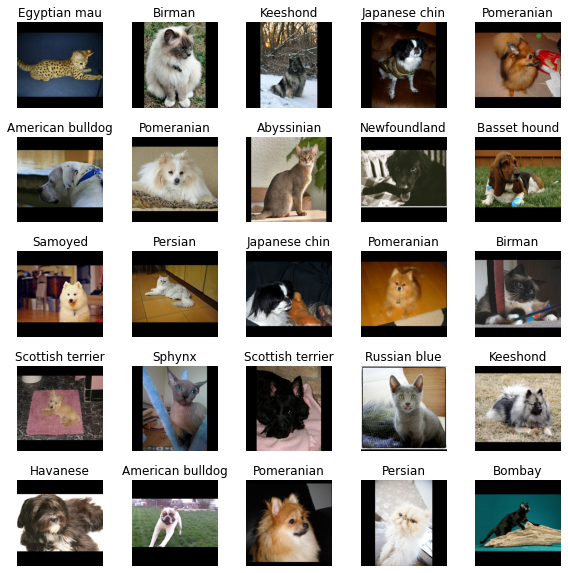

In [7]:
# Get the first 25 examples.
num_cols = num_rows = 5
x_slice, y_slice = train_ds.get_slice(begin=0, size=num_cols * num_rows)
train_y = [int(c) for c in y_slice]
train_x = tf.cast(x_slice, dtype="int32")  # casted so it can displayed

fig = plt.figure(figsize=(10.0, 10.0))
grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.4)

for ax, im, label in zip(grid, train_x, train_y):
    ax.imshow(im)
    ax.axis("off")
    ax.set_title(breeds[label])

## Model Building

Similarity models output a float embedding layer. Thanks to the loss, the model learns to minimize the distance between similar examples and maximize the distance between dissimilar examples. As a result, the distance between examples in the embedding space is meaningful; the smaller the distance the more similar the examples are.

Being able to use a distance as a meaningful proxy for how similar two examples are, is what enables the fast ANN (aproximate nearest neighbor) search. Using a sub-linear ANN search instead of a standard quadratic NN search is what allows deep similarity search to scale to millions of items. 

### Callbacks

Most metrics used to evaluate similarity models cannot be computed without indexing embeddings and performing query matching classification. TensorFlow Similarity provides callbacks that makes it easy to compute these performance metrics during training.

These callbacks work by taking two disjoint sets of examples:

1. A set of target examples and labels to be indexed. These will be examples returned by the search.
2. A set of query examples and labels that will be search query.

Then all metrics are computed be analyzing how many correct matches are returned by the search. While very very fast, this process is still too slow to be done for every training step. Instead the evaluation is only computed on_epoch_end().

Additionally, the EvalCallback() and SplitValidationLoss() are TensorBoard aware - just add a tf_logdir path as illustrated below to have your metric logged. 

In [8]:
# log_dir = "logs/%d/" % (time())
# tb_logdir=log_dir  # add if you want to track in tensorboard
# Adding the Tensorboard callback to track metrics in tensorboard.
# tbc = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# Setup EvalCallback by splitting the test data into targets and queries.
queries_x, queries_y = test_ds.get_slice(0, configs.num_queries)
targets_x, targets_y = test_ds.get_slice(configs.num_queries, configs.num_targets)
tsc = tfsim.callbacks.EvalCallback(
    queries_x,
    queries_y,
    targets_x,
    targets_y,
    metrics=["f1"],
    k=3,
)

# Setup SplitValidation callback.
val_loss = tfsim.callbacks.SplitValidationLoss(
    queries_x,
    queries_y,
    targets_x,
    targets_y,
    metrics=["binary_accuracy"],
    known_classes=tf.constant(train_cls),
    k=3,
)

callbacks = [
    val_loss,
    tsc,
    # tbc # uncomment if you want to track in tensorboard
]

In [9]:
# building model
model = tfsim.architectures.EfficientNetSim(
    train_ds.example_shape, 
    configs.embedding_size,
    pooling="gem",    # GeneralizedMeanPooling2D
    gem_p=3.0,        # Increase the contrast between activations in the feature map.
)

model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "similarity_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 gem_pool (GeneralizedMeanPo  (None, 1280)             0         
 oling2D)                                                        
                                                                 
 metric_embedding (MetricEmb  (None, 128)              163968    
 edding)                                                         
                                                                 
Total params: 4,213,539
Trainable params: 163,968
Non-trainable params: 4,049,571
___________________________________

## Transfer Learning: Loss definition and Model Compile

Metric losses expect different inputs. Instead of traditional loss having the prediction equal the true values, they expect embeddings as y_preds and the id (as an int32) of the class as y_true. They require a distance. You need to specify which distance function to use to compute the distance between embeddings. Here we are using the MultiSimilarityLoss(). This loss takes a weighted combination of all valid positive and negative pairs.

Tensorflow similarity use an extended compile() method that allows you to optionally specify distance_metrics (metrics that are computed over the distance between the embeddings), and the distance to use for the indexer. By default the compile() method tries to infer what type of distance you are using by looking at the fist loss specified. If you use multiple losses, and the distance loss is not the first one, then you need to specify the distance function used as distance= parameter in the compile function.

In [10]:
# init similarity loss
loss = tfsim.losses.MultiSimilarityLoss(distance='cosine')

# compiling and training
model.compile(optimizer=tf.keras.optimizers.Adam(configs.max_lr), loss=loss)

history = model.fit(
    train_ds,
    epochs=configs.n_epochs,
    steps_per_epoch=configs.steps_per_epoch,
    validation_data=test_ds,
    validation_steps=configs.val_steps,
    callbacks=callbacks,
)

Distance metric automatically set to cosine use the distance arg to override.
Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 1.6940Warmup complete
binary_accuracy_known_classes: 0.8537 - binary_accuracy_unknown_classes: 0.7053
f1: 0.8930
100/100 [==============================] - 45s 292ms/step - loss: 1.6940 - val_loss: 1.0868 - binary_accuracy_known_classes: 0.8537 - binary_accuracy_unknown_classes: 0.7053 - f1: 0.8930
Warmup complete
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 1.6509binary_accuracy_known_classes: 0.8585 - binary_accuracy_unknown_classes: 0.7474
f1: 0.9031
100/100 [==============================] - 25s 252ms/step - loss: 1.6509 - val_loss: 1.0708 - binary_accuracy_known_classes: 0.8585 - binary_accuracy_unknown_classes: 0.7474 - f1: 0.9031
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 1.6235binary_accuracy_known_classes: 0.8634 - binary_accuracy_unknown_classes: 0.6737
f1: 0.8909
100/100 [======

### Visualize Training history

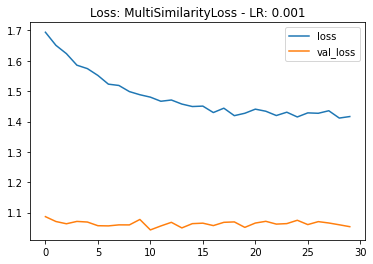

In [11]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title(f"Loss: {loss.name} - LR: {configs.max_lr}")
plt.show()

Using SplitValidationLoss() callback, we can contrast the binary accuracy for seen and unseen classes.

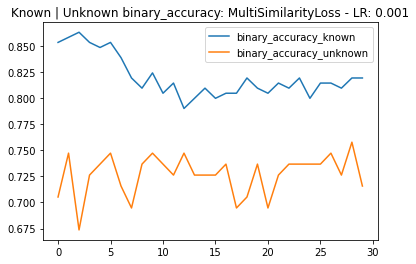

In [12]:
plt.plot(history.history["binary_accuracy_known_classes"])
plt.plot(history.history["binary_accuracy_unknown_classes"])
plt.legend(["binary_accuracy_known", "binary_accuracy_unknown"])
plt.title(f"Known | Unknown binary_accuracy: {loss.name} - LR: {configs.max_lr}")
plt.show()

## Model Evaluation

### Indexing

Indexing is where things get different from traditional classification models. Because the model learned to output an embedding that represent the example position within the learned metric space, we need a way to find which known example(s) are the closest to determine the class of the query example (aka nearest neighboors classication).

To do so, we are creating an index of known examples from all the classes present in the dataset. We do this by taking a total of 1280 examples from the test dataset which amount to 40 examples per class and we use the index() method of the model to build the index.

We store the images (index_x) as data in the index so that we can display them later. Here the images are small so its not an issue but in general, be careful while storing a lot of data in the index to avoid blewing up your memory. You might consider using a different Store() backend if you have to store and serve very large indexes.

Indexing more examples per class will help increase the accuracy/generalization, as having more variations improves the classifier "knowledge" of what variations to expect.

Reseting the index is not needed for the first run; however we shall be calling it to ensure we start the evaluation with a clean index in case of a partial re-run.

In [13]:
index_size = 1000
query_size = 600

index_x, index_y = test_ds.get_slice(0, index_size)
index_data = tf.cast(index_x, dtype="int32")

model.reset_index()
model.index(index_x, index_y, data=index_data)

[Indexing 1000 points]
|-Computing embeddings
|-Storing data points in key value store
|-Adding embeddings to index.
|-Building index.


### Calibration

To be able to tell if an example matches a given class, we first need to calibrate() the model to find the optimal cut point. This cut point is the maximum distance below which returned neighbors are of the same class. Increasing the threshold improves the recall at the expense of the precision.

Once the index is built, we can calibrate a distance threshold using a matching strategy and a calibration metric. All matches at or below the calibrated threshold distance will be labeled as a Positive match between the query example and the label associated with the match result, while all matches above the threshold distance will be labeled as a Negative match.

Additionally, we pass in extra metrics to compute as well. All values in the output are computed at the calibrated threshold.

In [14]:
x_train, y_train = train_ds.get_slice(begin=0, size=index_size)
calibration = model.calibrate(
    x_train,
    y_train,
    calibration_metric="f1",
    matcher="match_nearest",
    extra_metrics=["precision", "recall", "binary_accuracy"],
    verbose=1,
)


Performing NN search



Building NN list:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

computing thresholds:   0%|          | 0/999 [00:00<?, ?it/s]


 name       value    distance    precision    recall    binary_accuracy        f1
-------  -------  ----------  -----------  --------  -----------------  --------
optimal     0.97    0.053542        0.951         1              0.951  0.974885


### Precision/Recall curve

Precision - matching
Recall - percentage of the queries that we accept as positive matches

We can see in the precision/recall curve below, that the curve is not smooth. This is because the recall can improve independently of the precision causing a seesaw pattern.

Additionally, the model does extremly well on known classes and less well on the unseen ones, which contributes to the flat curve at the begining followed by a sharp decline as the distance threshold increases and examples are further away from the indexed examples.

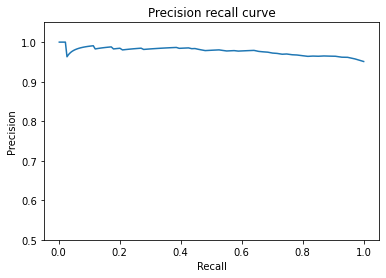

In [16]:
fig, ax = plt.subplots()
ax.plot(calibration.thresholds["recall"], calibration.thresholds["precision"])
ax.set_title("Precision recall curve")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_ylim((0.5, 1.05))
plt.show()

### Querying

To "classify" examples, we need to lookup their k nearest neighbors in the index.

Here we going to query a single random example for each class from the test dataset using gather() and then find their five nearest neighbors using the lookup() function.

**NOTE: Few classes were not used during training, but we still get reasonable matches for them**

In [17]:
# what will be used as never seen before queries to test performance
test_x, test_y = test_ds.get_slice(index_size, query_size)
test_y = [int(c) for c in test_y]
test_data = tf.cast(test_x, dtype="int32")


Performing NN search



Building NN list:   0%|          | 0/5 [00:00<?, ?it/s]

**Unknown Class**

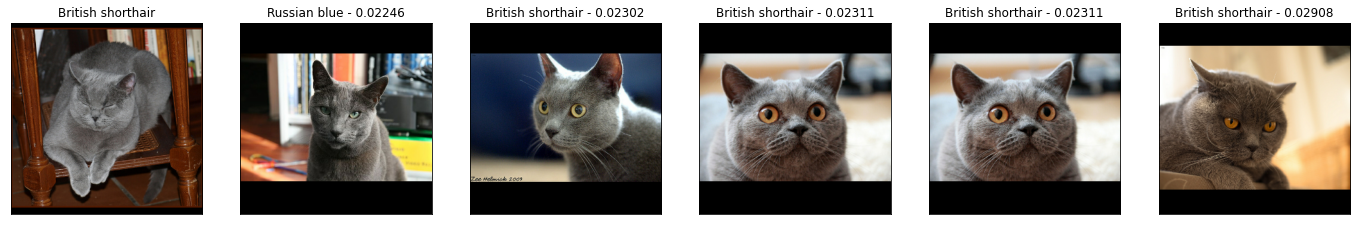

**Known Class**

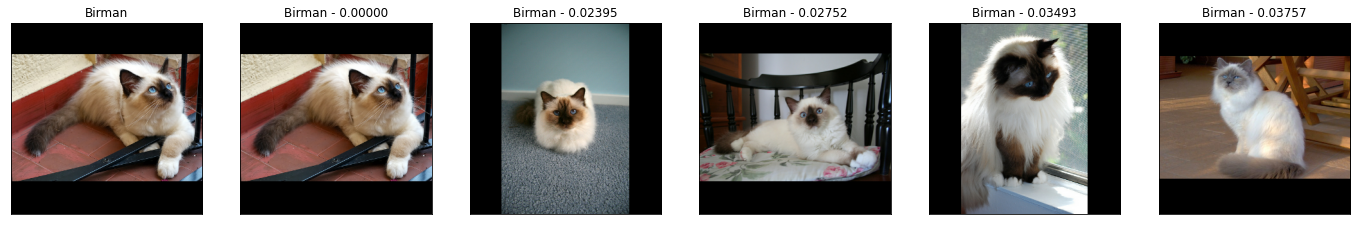

**Unknown Class**

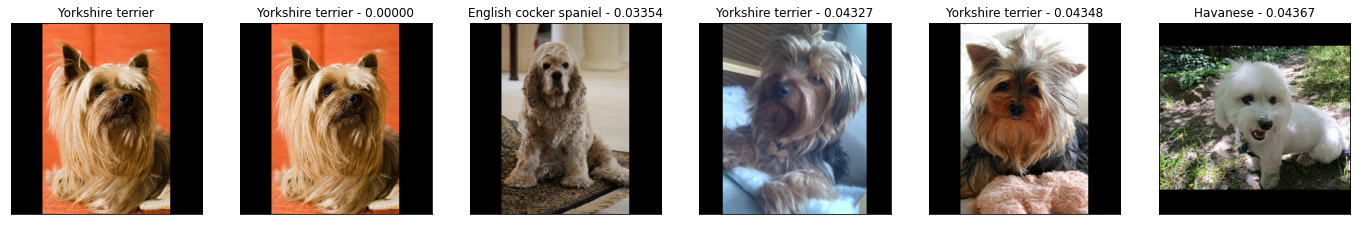

**Known Class**

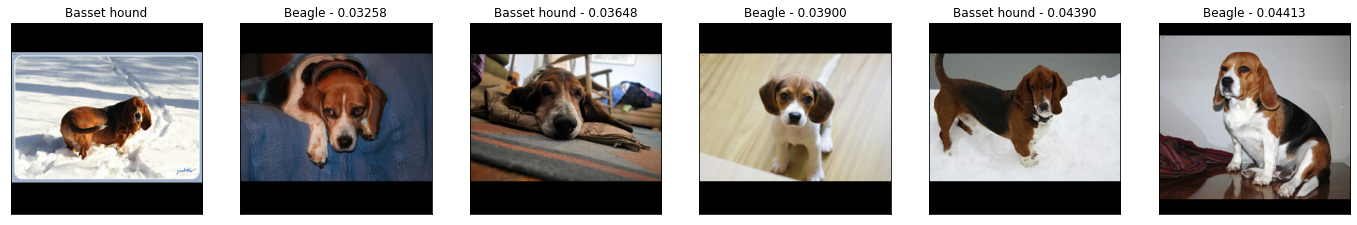

**Known Class**

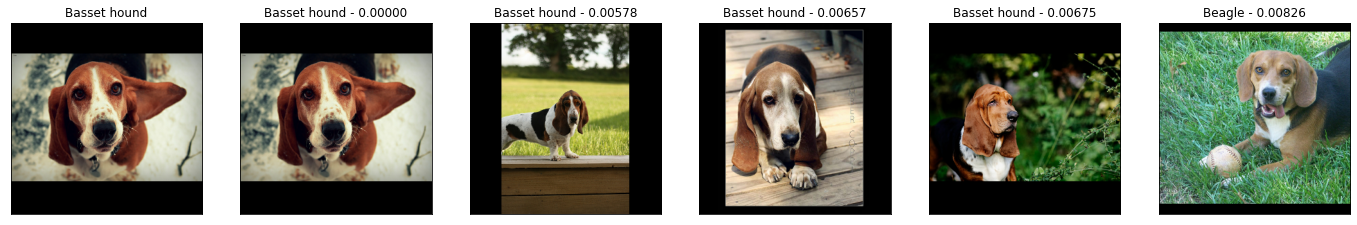

In [18]:
num_examples = 5
num_neigboors = 5
idxs = random.sample(range(len(test_y)), num_examples)
batch = tf.gather(test_x, idxs)
nns = model.lookup(batch, k=num_neigboors)
for bid, nn in zip(idxs, nns):
    # view results close by
    if test_y[bid] in train_cls:
        display(Markdown("**Known Class**"))
    else:
        display(Markdown("**Unknown Class**"))
    tfsim.visualization.viz_neigbors_imgs(test_data[bid], test_y[bid], nn, class_mapping=breeds, cmap="Greys")

### Confusion Matrix

We can also take 100 examples for each class and plot the confusion matrix for each example and their nearest match. We also add an "extra" class to represent the matches above the calibrated distance threshold.


The purpose of match() is to allow you to use your similarity models to make classification predictions. It accomplishes this by finding the nearest neigbors for a set of query examples and returning an infered label based on neighbors labels and the matching strategy used (MatchNearest by default).

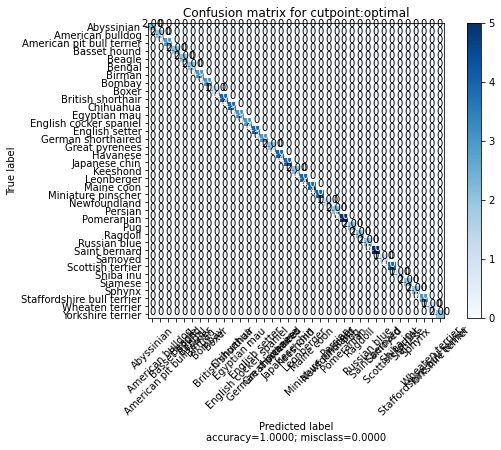

(<matplotlib.axes._subplots.AxesSubplot at 0x7fdd44665d10>,
 <tf.Tensor: shape=(37, 37), dtype=float32, numpy=
 array([[2., 0., 0., ..., 0., 0., 0.],
        [0., 2., 0., ..., 0., 0., 0.],
        [0., 0., 3., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 3., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 2.]], dtype=float32)>)

In [19]:
cutpoint = "optimal"
x_confusion, y_confusion = test_ds.get_slice(0, 100)

matches = model.match(x_confusion, cutpoint=cutpoint, no_match_label=24)
tfsim.visualization.confusion_matrix(
    matches,
    y_confusion,
    labels=list(breeds.values()),
    title="Confusion matrix for cutpoint:%s" % cutpoint,
    normalize=False,
)

We can plot the examples outside of the calibrated threshold to see which images are not matching any indexed examples.

This may provide insight into what other examples may need to be indexed or surface anomalous examples within the class.

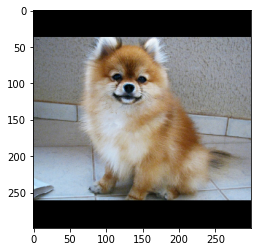

In [24]:
idx_no_match = np.where(np.array(matches) == 24)
no_match_queries = x_confusion[idx_no_match]
if len(no_match_queries):
    img = tf.cast(no_match_queries[0], dtype="int32")
    plt.imshow(img)
else:
    print("All queries have a match below the distance threshold.")

Get information about the index configuration and its performance

In [25]:
model.index_summary()

[Info]
------------------  ------
distance            cosine
key value store     memory
search algorithm    nmslib
evaluator           memory
index size          1000
calibrated          True
calibration_metric  f1
embedding_output
------------------  ------



[Performance]
-----------  --------------
num lookups  1105
min             1.46437e-05
max             0.00552959
avg             6.44414e-05
median          3.94738e-05
stddev          0.000387486
-----------  --------------


### Visualize clusters

One of the best ways to quickly get a sense of the quality of how the model is doing and understand it's short comings is to project the embedding into a 2D space. This allows us to inspect clusters of images and understand which classes are entangled.

In [26]:
num_examples_to_clusters = 1000
thumb_size = 96  
plot_size = 800
vx, vy = test_ds.get_slice(0, num_examples_to_clusters)
tfsim.visualization.projector(
    model.predict(vx), labels=vy, images=vx, class_mapping=breeds, image_size=thumb_size, plot_size=plot_size
)

perfoming projection using UMAP


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


generating diplayabe images:   0%|          | 0/1000 [00:00<?, ?it/s]

**Looking at the model result, it does surprisingly returns similar results. The model is able to find images of similar looking animals irrespective of their pose or image illumination.**